In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import seed_random_generators
seed_random_generators()

In [3]:
from pathlib import Path
OUTPUT_DIR = Path("output").joinpath("baseline")

from utils import safe_clear_output_dir
safe_clear_output_dir(OUTPUT_DIR)

Cleared 4 files from output\baseline


# Load Data

In [4]:
from npz_loader import load_episodes

dataset_root = Path("dataset")
holdout_game_dirs = [
    dataset_root.joinpath("BeamRiderNoFrameskip-v4", "BeamRiderNoFrameskip-v4"),
    # dataset_root.joinpath("BreakoutNoFrameskip-v4", "BreakoutNoFrameskip-v4")
]

main_game_dirs = [
    dataset_root.joinpath("EnduroNoFrameskip-v4", "EnduroNoFrameskip-v4"),
    dataset_root.joinpath("MsPacmanNoFrameskip-v4", "MsPacmanNoFrameskip-v4"),
    # dataset_root.joinpath("PongNoFrameskip-v4", "PongNoFrameskip-v4"),
    # dataset_root.joinpath("QbertNoFrameskip-v4", "QbertNoFrameskip-v4"),
    # dataset_root.joinpath("SeaquestNoFrameskip-v4", "SeaquestNoFrameskip-v4"),
    # dataset_root.joinpath("SpaceInvadersNoFrameskip-v4", "SpaceInvadersNoFrameskip-v4")
]
episodes = load_episodes(main_game_dirs, holdout_game_dirs)

Loaded 880 episodes


In [5]:
from utils import sample_list
sampled_episodes = sample_list(episodes, fraction=0.05)

Sampled 44 items (5.0% of 880 total)


In [6]:
from epsiode_dataloader import make_train_val_dataloaders

main_bundle, holdout_bundle, bins = make_train_val_dataloaders(
    episodes=sampled_episodes,
    holdout_game_dirs=holdout_game_dirs,
    train_frac=0.8,
    timestep_window_size=4,
)

# Dataloader - Main Games

Saved plot to output\baseline\dataloader_main_train.png


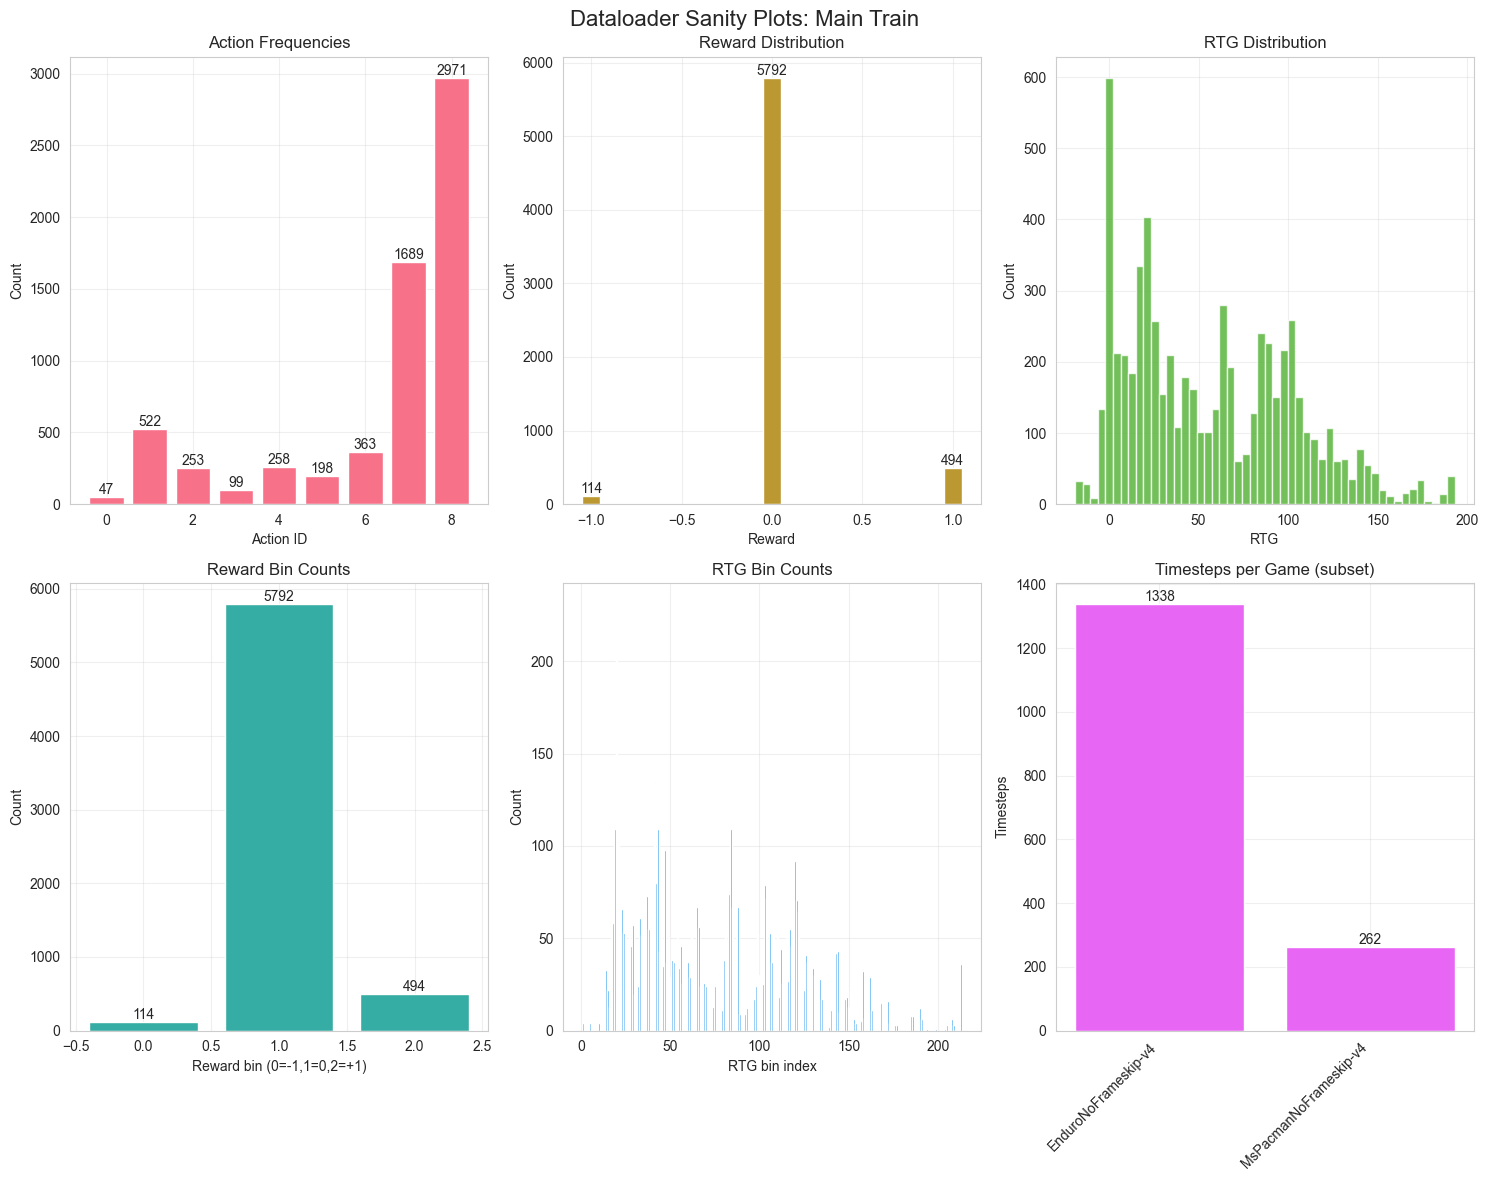

Dataloader size: 1148
Saved plot to output\baseline\dataloader_main_validate.png


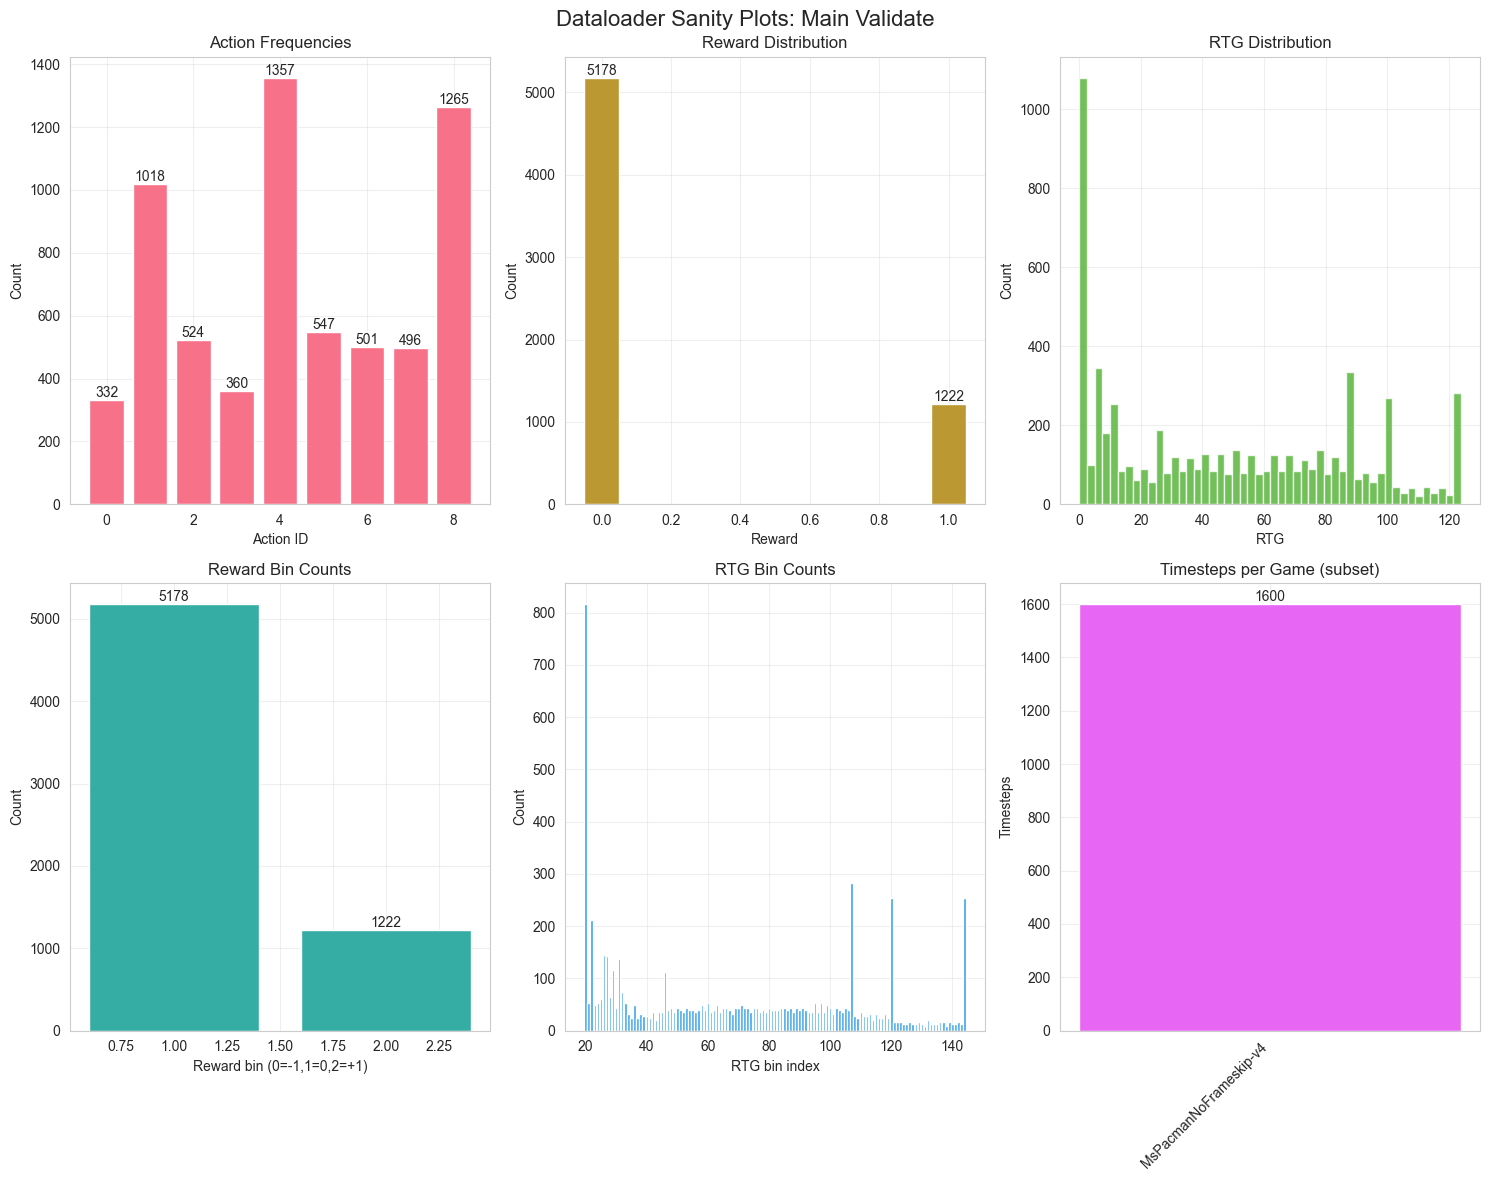

Dataloader size: 180


In [7]:
from dataloader_stats import inspect_dataloader

_ = inspect_dataloader(main_bundle.train_loader, "Main Train", output_dir=OUTPUT_DIR)
_ = inspect_dataloader(main_bundle.val_loader, "Main Validate", output_dir=OUTPUT_DIR)

# Dataloader - Holdout Games

Saved plot to output\baseline\dataloader_holdout_train.png


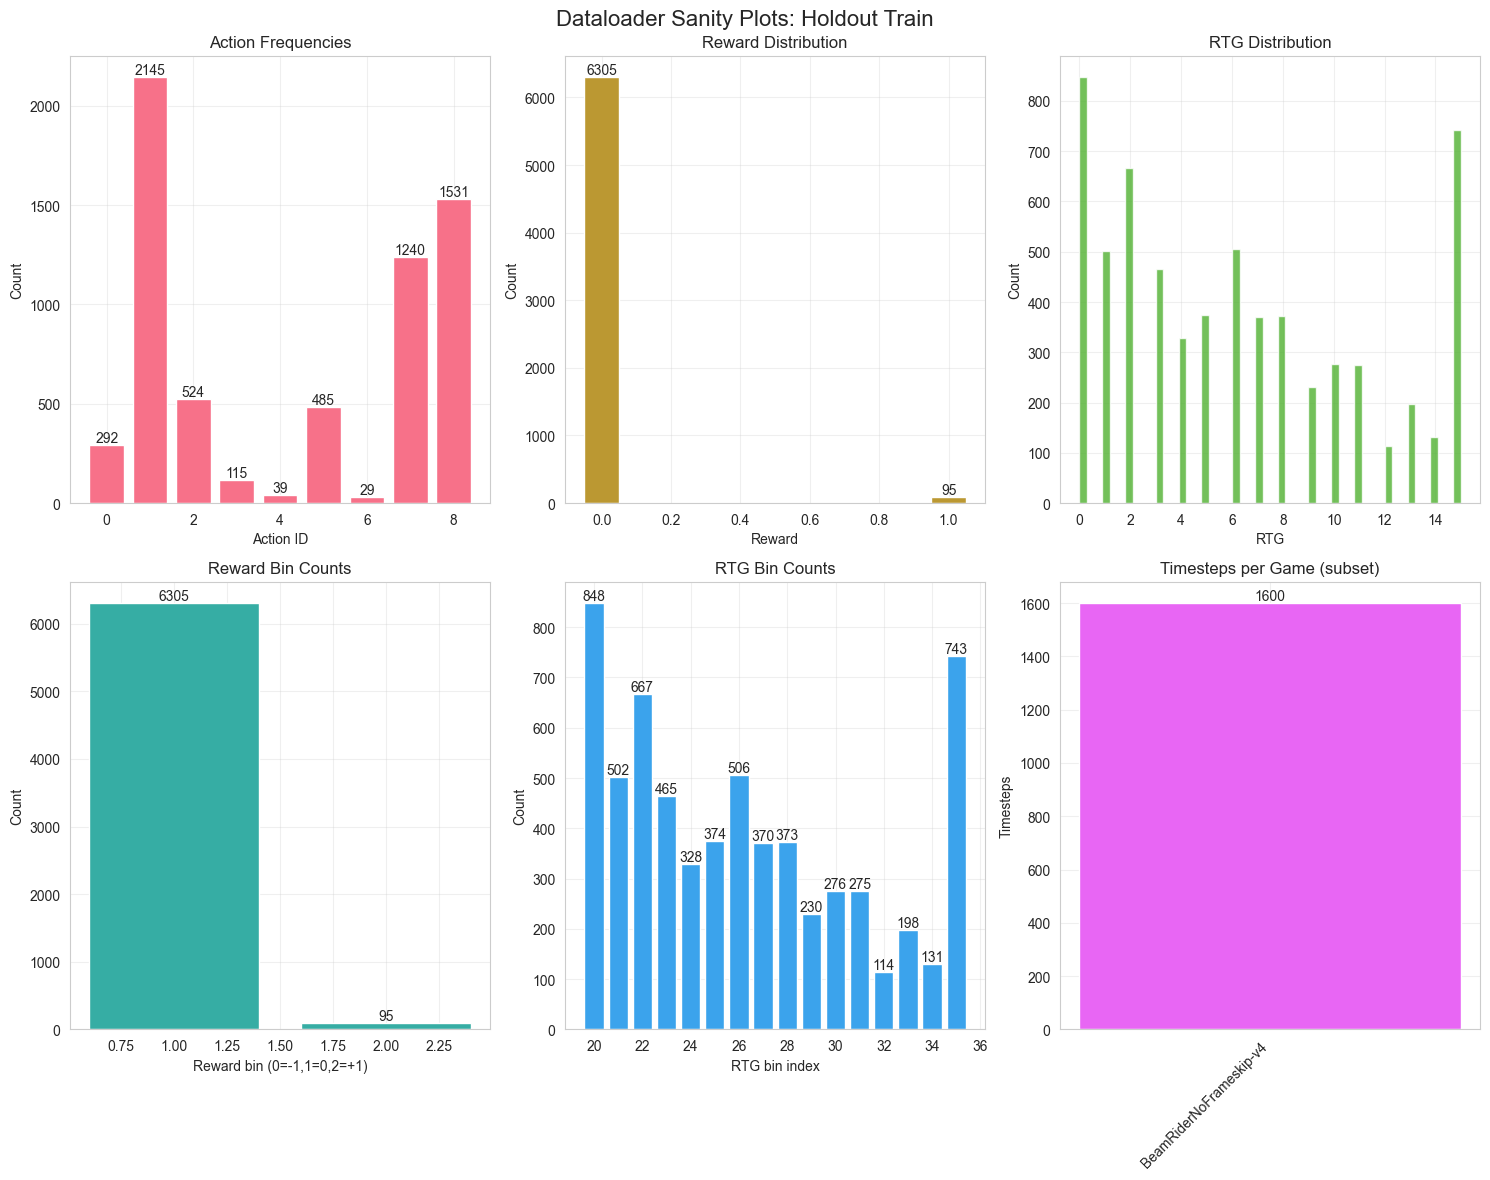

Dataloader size: 140
Saved plot to output\baseline\dataloader_holdout_validate.png


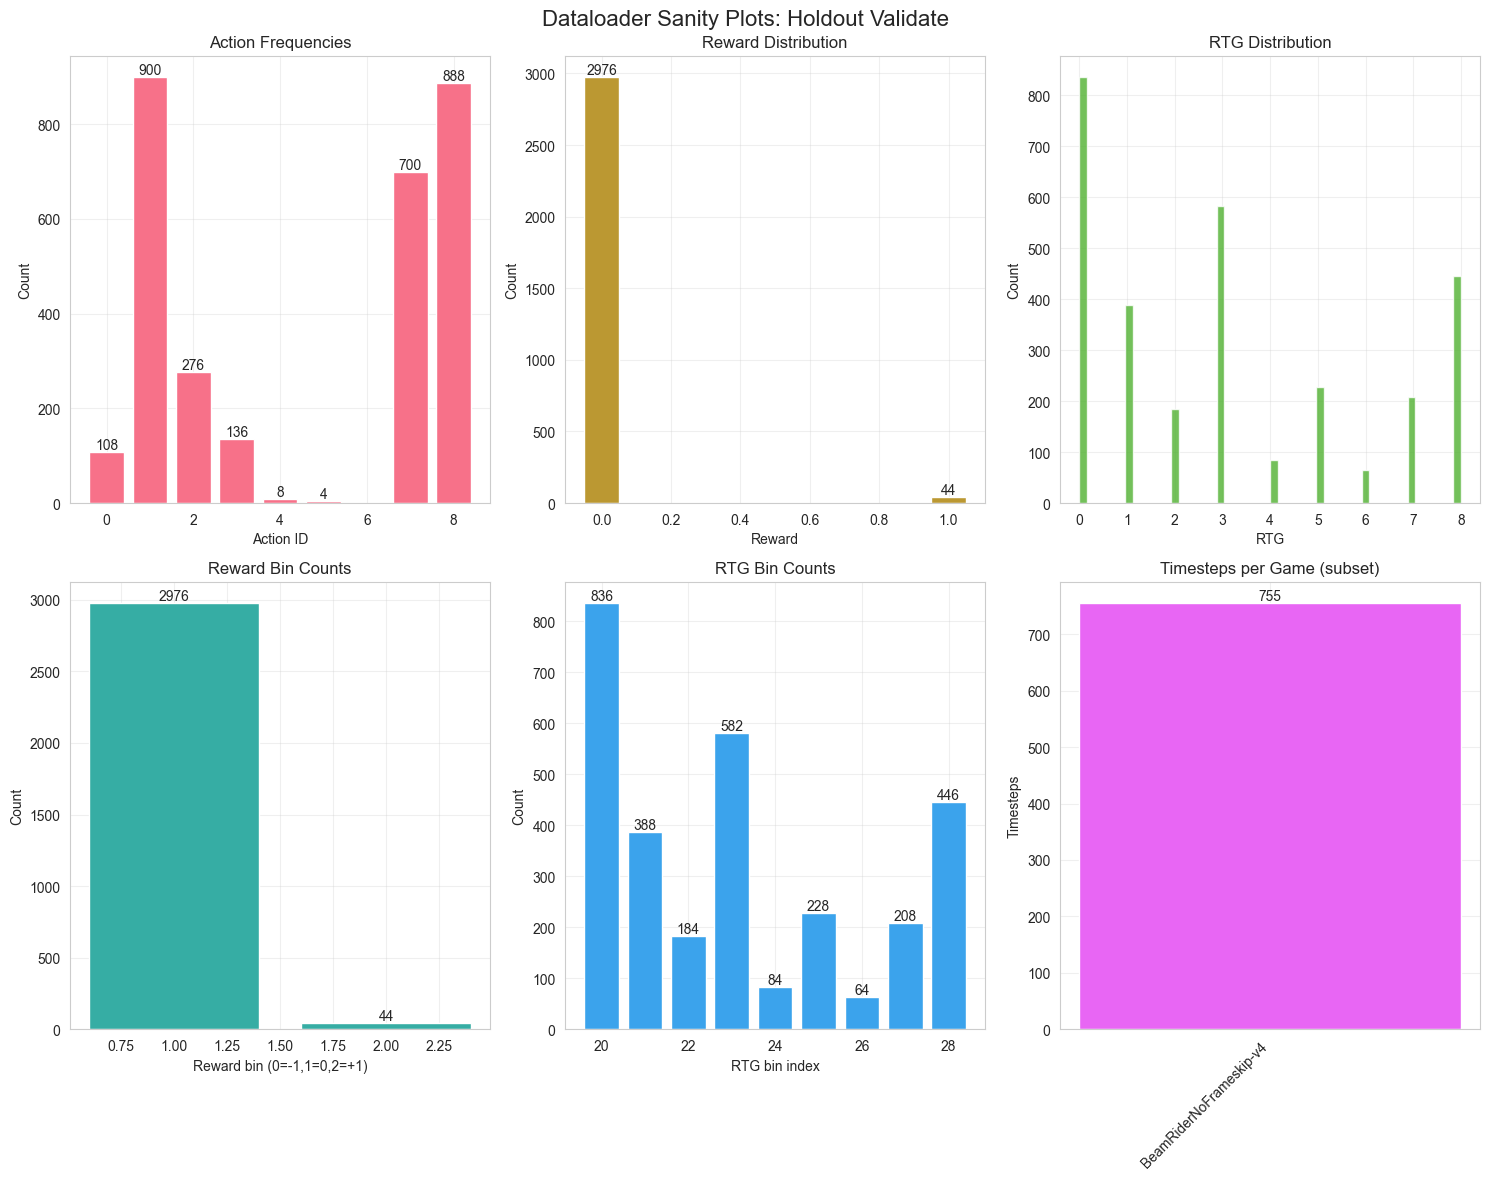

Dataloader size: 24


In [8]:
_ = inspect_dataloader(holdout_bundle.train_loader, "Holdout Train", output_dir=OUTPUT_DIR)
_ = inspect_dataloader(holdout_bundle.val_loader, "Holdout Validate", output_dir=OUTPUT_DIR)

# Train - Main Games

In [9]:
from mgdt_model_trainer import Encoder, train_mgdt

model, main_train_stats, main_val_stats = train_mgdt(
    bins=bins,
    dataloader_train=main_bundle.train_loader,
    dataloader_val=main_bundle.val_loader,
    encoder_type=Encoder.Patch,
    num_epochs=2,
)

Epoch 2/2: 100%|██████████| 1148/1148 [01:16<00:00, 15.01it/s]


Saved plot to output\baseline\model_main_losses_per_head.png


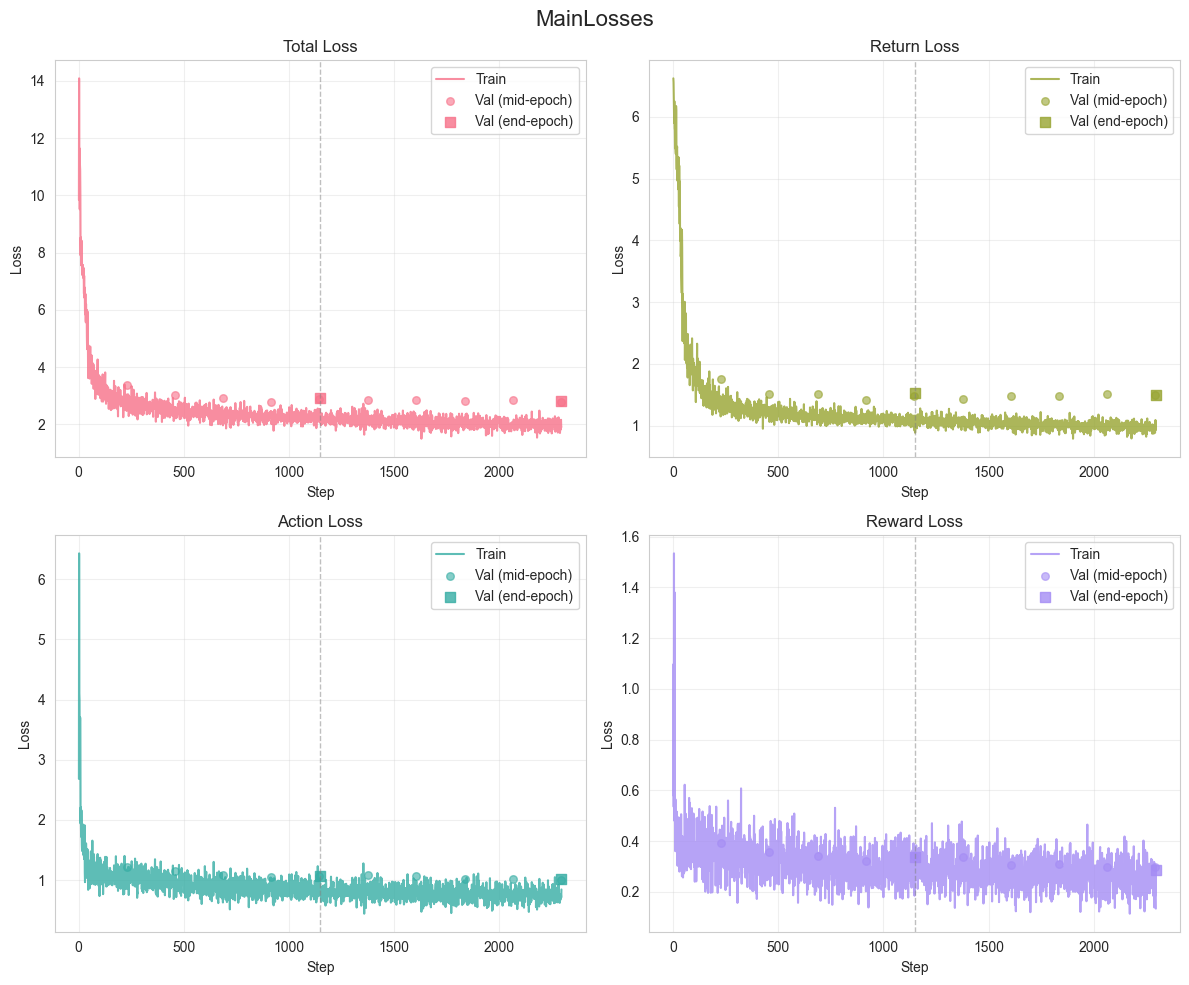

Saved plot to output\baseline\model_main_losses_combined.png


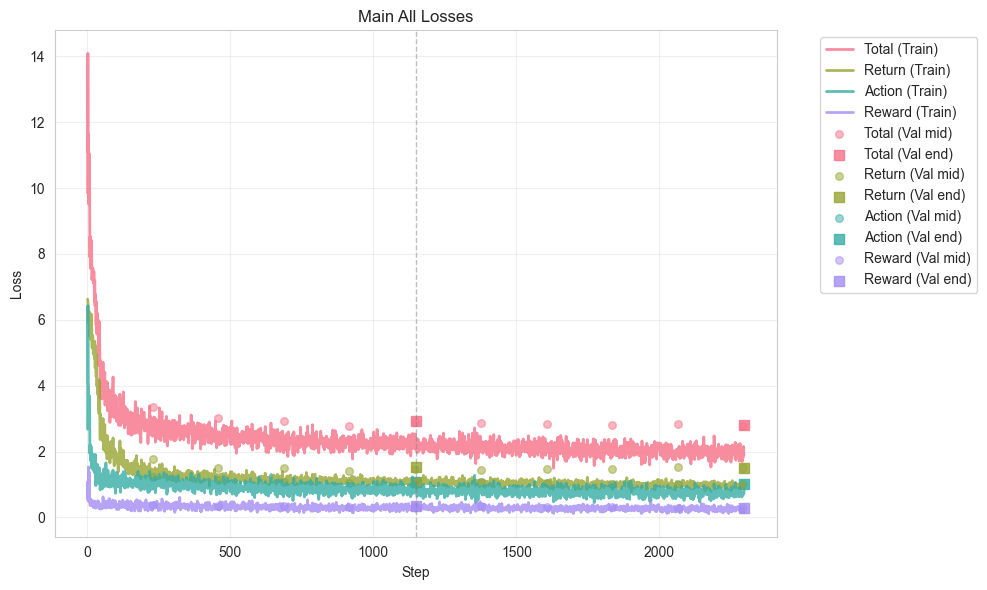

Saved plot to output\baseline\model_main_losses_ema_per_head.png


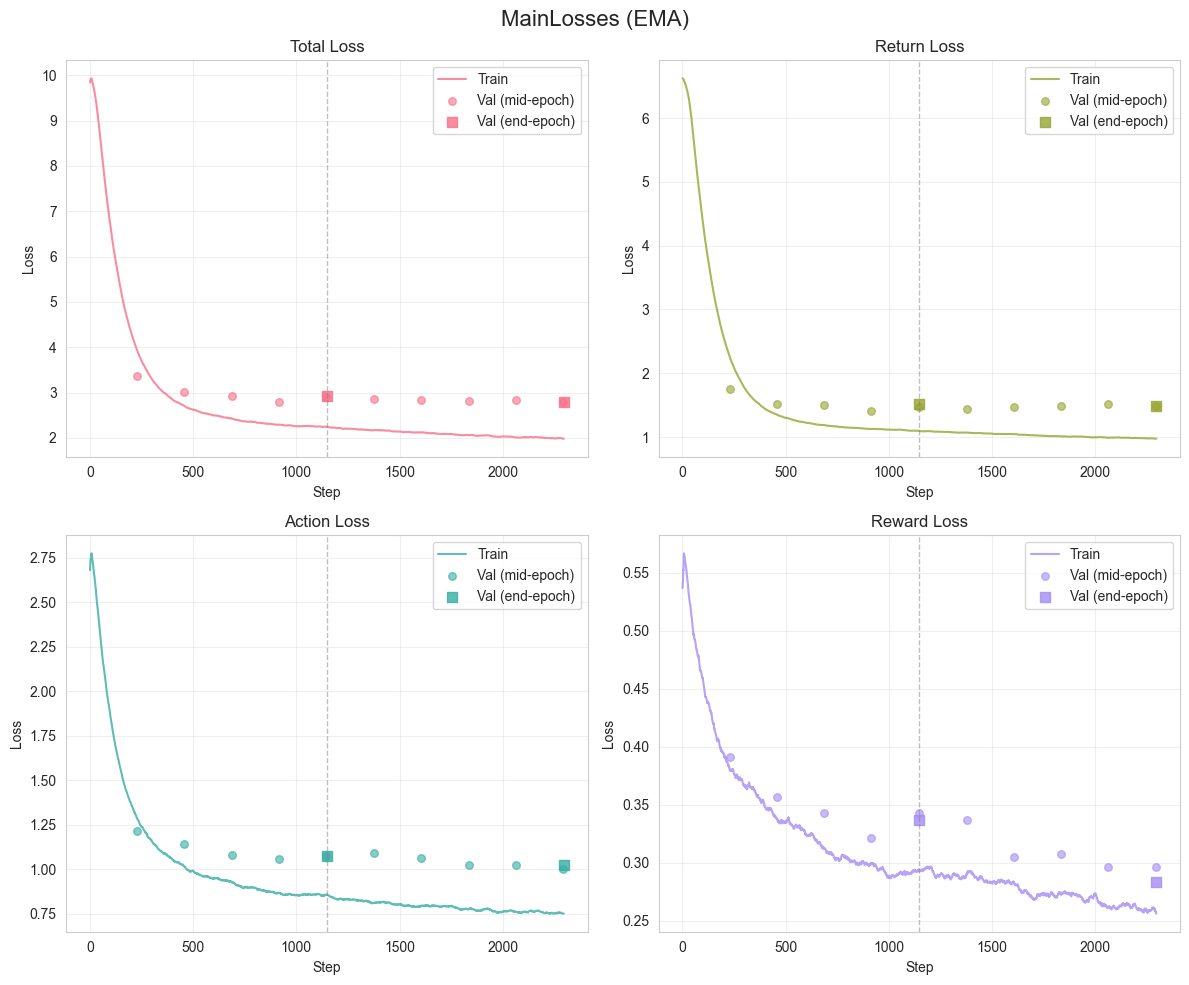

Saved plot to output\baseline\model_main_losses_ema_combined.png


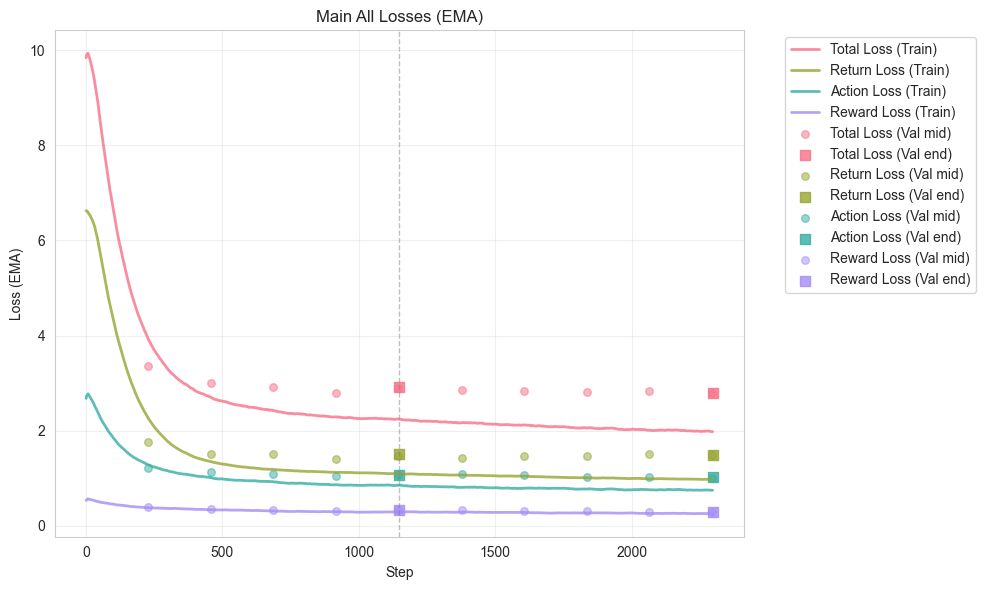

In [10]:
from mgdt_model_stats import plot_losses
plot_losses(main_train_stats, main_val_stats, output_dir=OUTPUT_DIR, title_prefix="Main")

# Test Freeze

In [11]:
from mgdt_model import Freezeable
model.freeze(components=[Freezeable.Transformer])

# Train - Holdout Games

In [12]:
from mgdt_model_trainer import Encoder, train_mgdt

model, holdout_train_stats, holdout_val_stats = train_mgdt(
    model=model,
    bins=bins,
    dataloader_train=holdout_bundle.train_loader,
    dataloader_val=holdout_bundle.val_loader,
    encoder_type=Encoder.Patch,
    num_epochs=1,
)

Finetune 1/1: 100%|██████████| 140/140 [00:27<00:00,  5.13it/s]


Saved plot to output\baseline\model_holdout_losses_per_head.png


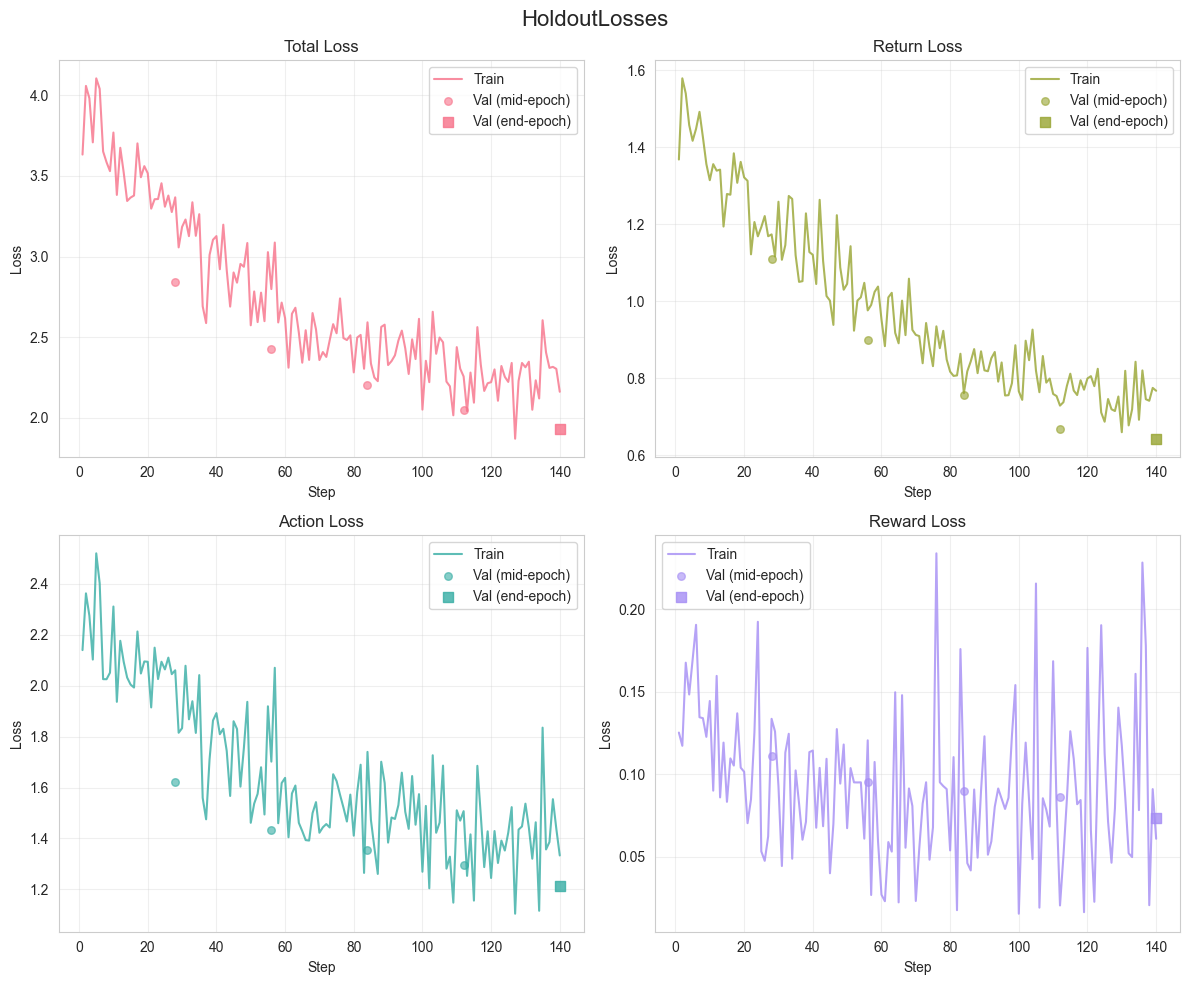

Saved plot to output\baseline\model_holdout_losses_combined.png


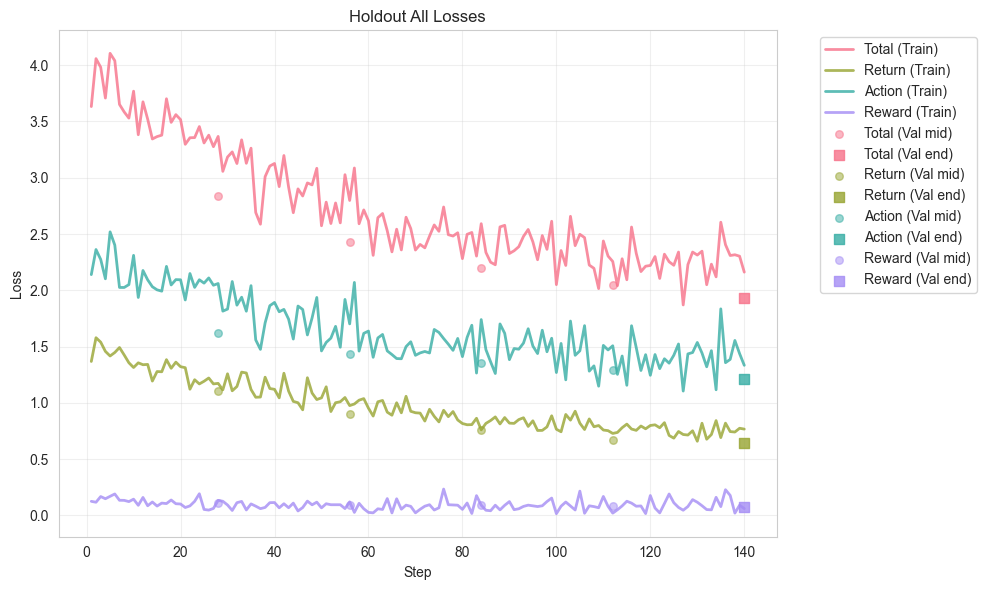

Saved plot to output\baseline\model_holdout_losses_ema_per_head.png


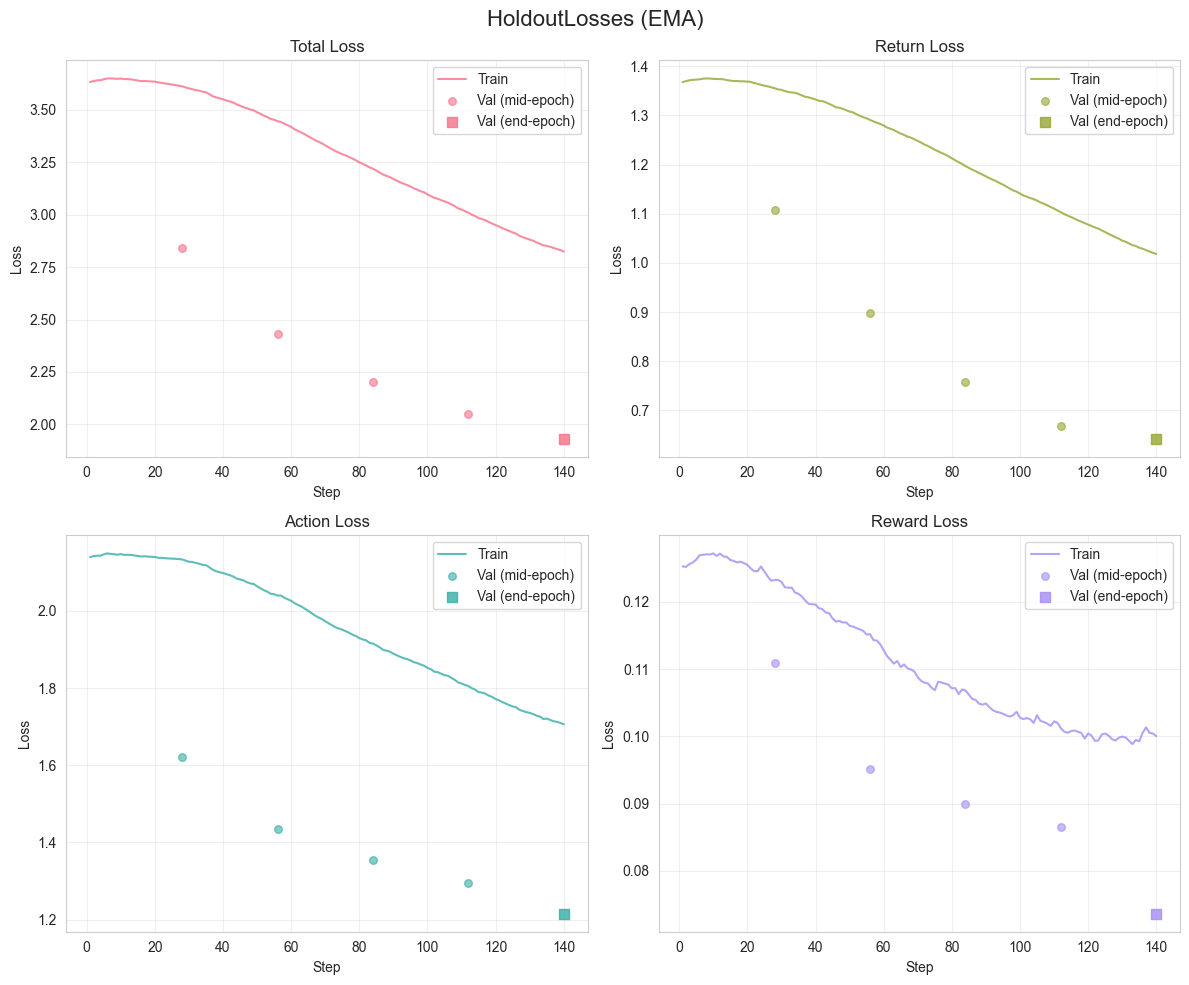

Saved plot to output\baseline\model_holdout_losses_ema_combined.png


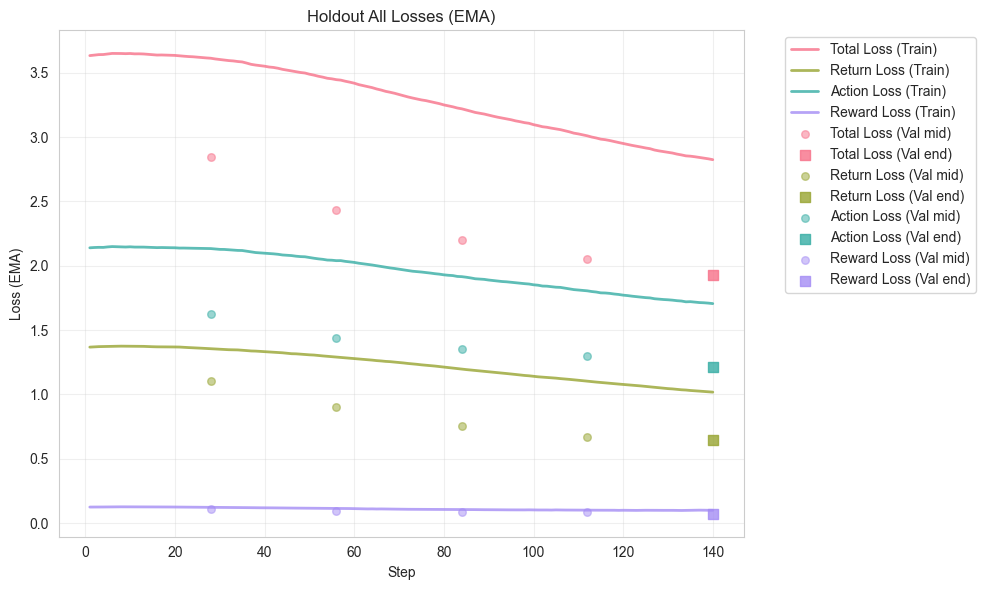

In [13]:
from mgdt_model_stats import plot_losses
plot_losses(holdout_train_stats, holdout_val_stats, output_dir=OUTPUT_DIR, title_prefix="Holdout")

# Comparison

Saved plot to output\baseline\comparison_baseline_main_vs_holdout.png


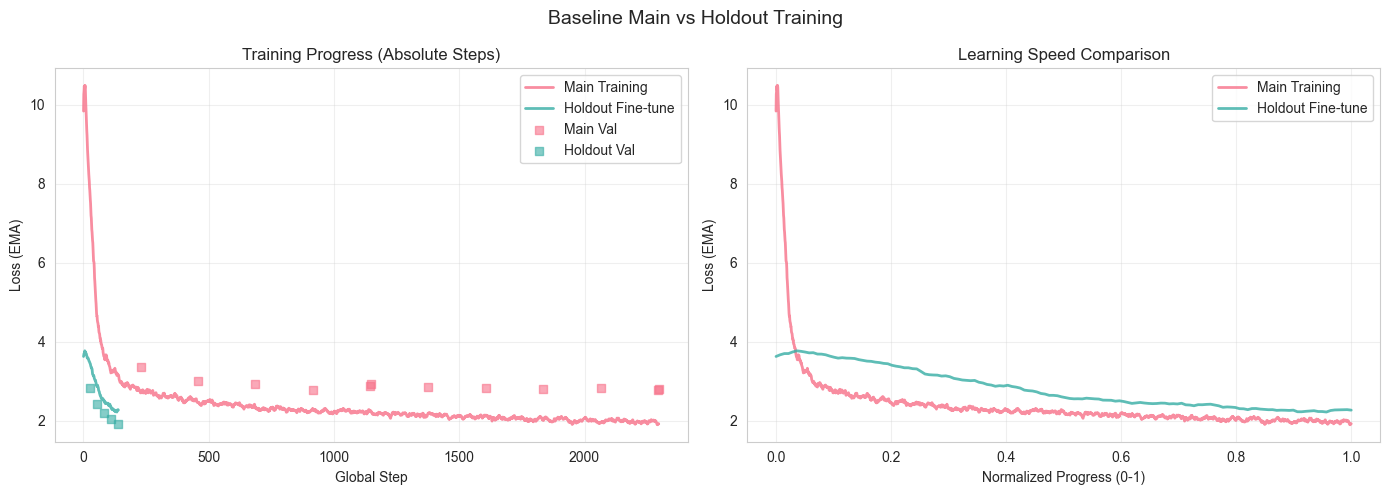

Saved plot to output\baseline\comparison_baseline_per_head_loss.png


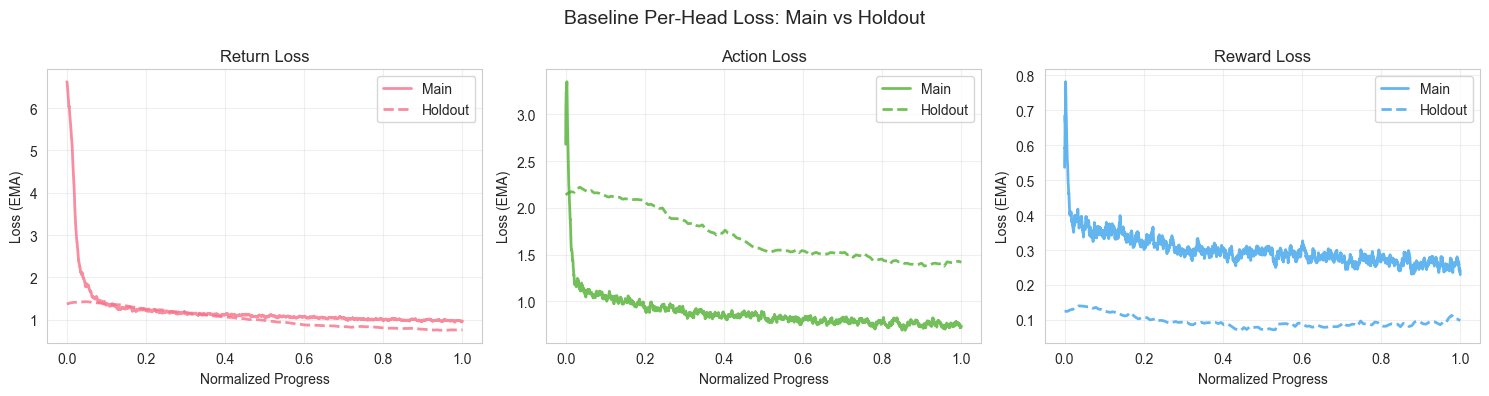

Saved plot to output\baseline\comparison_baseline_accuracy.png


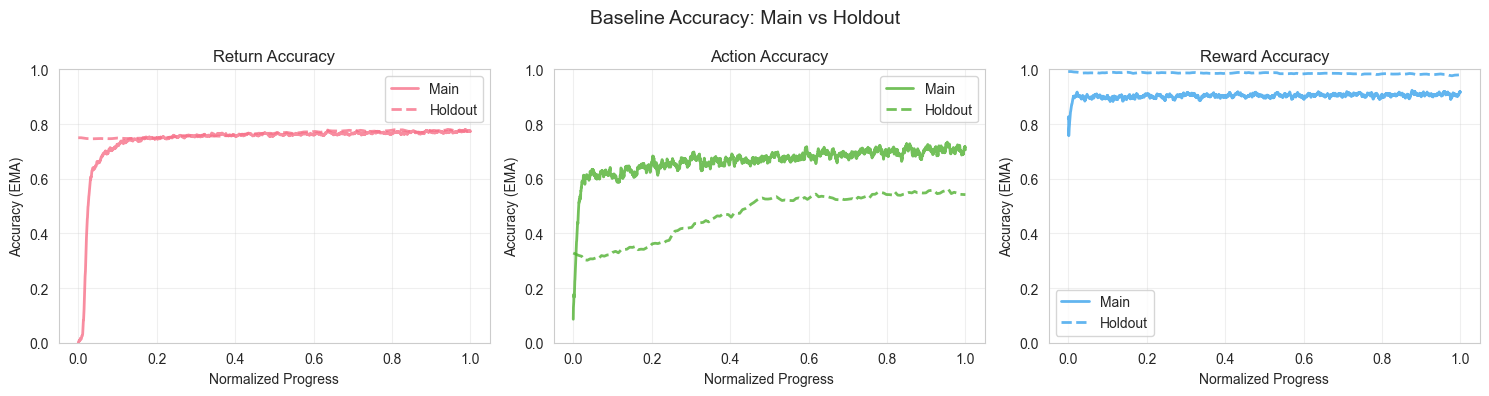


HOLDOUT ADAPTATION SUMMARY
Main training steps: 2296
Holdout fine-tune steps: 140

Main training - Final loss (EMA): 1.9302
Holdout fine-tune - Initial loss (EMA): 3.6325
Holdout fine-tune - Final loss (EMA): 2.2743
Holdout loss reduction: 1.3582

Holdout did not reach main's final loss of 1.9302


In [14]:
from mgdt_model_stats import plot_holdout_comparison

plot_holdout_comparison(main_train_stats, main_val_stats, holdout_train_stats, holdout_val_stats, output_dir=OUTPUT_DIR, title_prefix="Baseline")

# Model Info and Save

In [15]:
total_params = sum(param.numel() for param in model.parameters())
print(f"Total parameters: {total_params/1e6:.0f}M")

Total parameters: 20M


In [16]:
from utils import save_checkpoint

save_checkpoint(model, main_train_stats, main_val_stats, output_dir=OUTPUT_DIR)

Model and stats saved to output\baseline\model.pt


WindowsPath('output/baseline/model.pt')

# Del Model to Free Mem

In [18]:
import gc
import torch

if model is not None:
    del model
    model = None

gc.collect()
torch.cuda.empty_cache()